In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.metrics import accuracy_score
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OrdinalEncoder
np.random.seed(42)
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder

import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

In [ ]:
folder_benign_train = '/content/drive/MyDrive/MachineLearning_dataset/data/train/benign'
folder_malignant_train = '/content/drive/MyDrive/MachineLearning_dataset/data/train/malignant'

folder_benign_test = '/content/drive/MyDrive/MachineLearning_dataset/data/test/benign'
folder_malignant_test = '/content/drive/MyDrive/MachineLearning_dataset/data/test/malignant'

read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

# Load in training pictures 
ims_benign = [read(os.path.join(folder_benign_train, filename)) for filename in os.listdir(folder_benign_train)]
X_benign = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_train, filename)) for filename in os.listdir(folder_malignant_train)]
X_malignant = np.array(ims_malignant, dtype='uint8')

# Load in testing pictures
ims_benign = [read(os.path.join(folder_benign_test, filename)) for filename in os.listdir(folder_benign_test)]
X_benign_test = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_test, filename)) for filename in os.listdir(folder_malignant_test)]
X_malignant_test = np.array(ims_malignant, dtype='uint8')

# Create labels
Y_benign = np.zeros(X_benign.shape[0])
Y_malignant = np.ones(X_malignant.shape[0])

Y_benign_test = np.zeros(X_benign_test.shape[0])
Y_malignant_test = np.ones(X_malignant_test.shape[0])


# Merge data 
X_train = np.concatenate((X_benign, X_malignant), axis = 0)
Y_train = np.concatenate((Y_benign, Y_malignant), axis = 0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis = 0)
Y_test = np.concatenate((Y_benign_test, Y_malignant_test), axis = 0)

# Shuffle data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

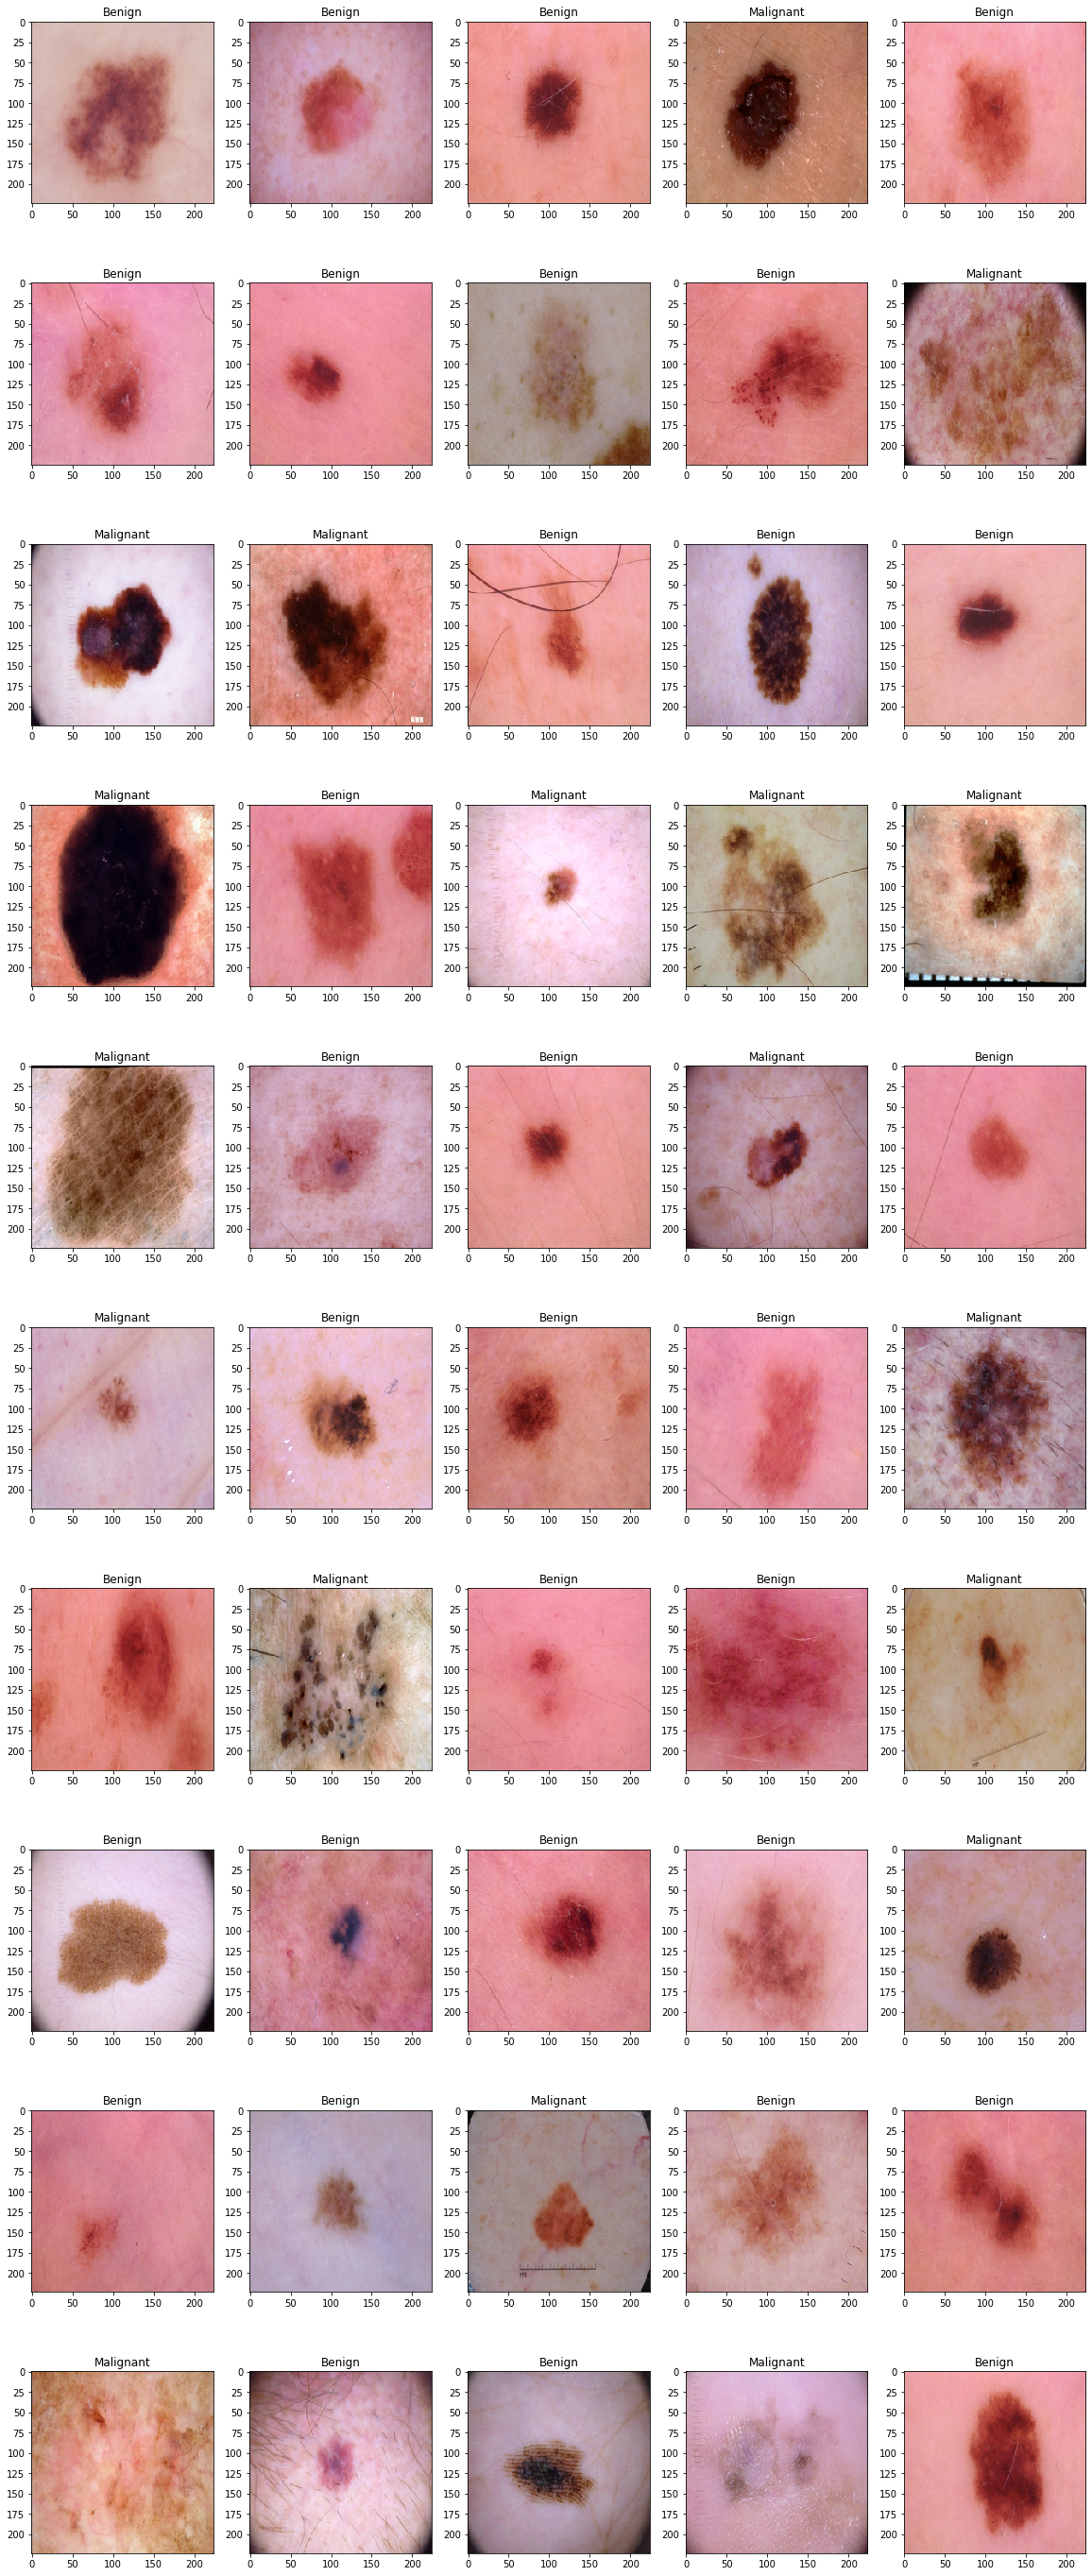

In [ ]:
fig=plt.figure(figsize=(20, 50))
columns = 5
rows = 10

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if Y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()

In [ ]:
print('Shapes: \n')
print('X_train: ',X_train.shape,' \n')
print('Y_train: ',Y_train.shape,' \n')
print('X_test : ',X_test.shape,' \n')
print('Y_test : ',Y_test.shape,' \n')
print('Y_train malginant Distrib: ',(Y_train.sum()/len(Y_train)).round(4), '\n')
print('Y_test malginant Distrib: ',(Y_test.sum()/len(Y_test)).round(4), '\n')

In [ ]:
#Subsampling to prior CNN model evaluation
Sample1 = np.random.choice(range(0,len(X_train)), size=1000, replace=False)
Sample1
Sample2 = np.random.choice(range(0,len(X_test)), size=600, replace=False)
Sample2

array([526,  10, 469, 253,   4, 452, 384, 139, 341, 593, 193, 626, 451,
       197, 466, 301, 458, 227, 332, 159, 135, 561, 454, 574, 217, 607,
       254,  50, 654, 241, 101, 290, 356, 514, 132, 402, 578, 632, 123,
       315, 130, 338, 334, 495, 347, 138, 390,  90, 119, 210, 615, 491,
       158, 155, 508, 524, 411,  32, 419, 249, 506, 313, 658, 456, 407,
       321, 258, 149, 555, 596, 476, 622, 120,  54, 414, 225, 541, 362,
       389, 391,  76, 614, 641, 463, 518, 372, 203, 162, 444, 413, 370,
       230,  83, 287, 144, 204,  11, 484, 549, 457,   1,  18,  95, 168,
       228, 348, 355, 399,  45, 211, 277, 107, 450,  52,  43, 597,  22,
       435, 589,  42, 285, 453, 294, 569, 652, 404, 363, 250, 353,  60,
       520, 479, 542, 137, 166, 261, 180, 128, 316, 179, 335,  56, 118,
       212, 239, 237, 141, 276,  16, 576, 349, 564,  30, 445, 378, 368,
       242, 233, 505, 337, 446, 320, 382, 616, 305, 201, 582, 386, 238,
       583,  19, 265, 408, 609, 546, 395, 148,  28, 247, 385,  5

In [ ]:
X_train_sample = X_train[Sample1]
Y_train_sample = Y_train[Sample1]
X_test_sample = X_test[Sample2]
Y_test_sample = Y_test[Sample2]

In [ ]:
X_train_sample.shape

(1000, 224, 224, 3)

In [ ]:
Y_train_sample.shape

(1000,)

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-7)

In [ ]:
num_classes = 1
SIZE = 224            
kern_size = 3


model = Sequential()
model.add(Conv2D(filters=20, kernel_size=(kern_size, kern_size), activation="relu", input_shape=(SIZE, SIZE, 3)))
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(filters=20, kernel_size=(kern_size, kern_size), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))


model.add(Conv2D(filters=20, kernel_size=(kern_size, kern_size),activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.2))


model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()


model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=["BinaryAccuracy"])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 222, 222, 20)      560       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 111, 111, 20)      0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 111, 111, 20)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 109, 109, 20)      3620      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 54, 54, 20)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 54, 54, 20)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 52, 52, 20)       

In [ ]:
batch_size = 20 
epochs = 100

history = model.fit(
    X_train_sample, Y_train_sample,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(X_test_sample, Y_test_sample),
    verbose=2,
    callbacks=[ModelCheckpoint("SequentialModel1.h5", monitor='val_binary_accuracy',save_weights_only=True, mode='max', save_best_only=True, verbose=2)])

Epoch 1/100
50/50 - 2s - loss: 42.7419 - binary_accuracy: 0.5330 - val_loss: 0.6916 - val_binary_accuracy: 0.4567

Epoch 00001: val_binary_accuracy improved from -inf to 0.45667, saving model to SequentialModel1.h5
Epoch 2/100
50/50 - 1s - loss: 0.9240 - binary_accuracy: 0.5780 - val_loss: 0.6897 - val_binary_accuracy: 0.5117

Epoch 00002: val_binary_accuracy improved from 0.45667 to 0.51167, saving model to SequentialModel1.h5
Epoch 3/100
50/50 - 1s - loss: 0.7065 - binary_accuracy: 0.6690 - val_loss: 0.6930 - val_binary_accuracy: 0.4600

Epoch 00003: val_binary_accuracy did not improve from 0.51167
Epoch 4/100
50/50 - 1s - loss: 0.6502 - binary_accuracy: 0.6580 - val_loss: 0.6735 - val_binary_accuracy: 0.5867

Epoch 00004: val_binary_accuracy improved from 0.51167 to 0.58667, saving model to SequentialModel1.h5
Epoch 5/100
50/50 - 1s - loss: 0.6199 - binary_accuracy: 0.6590 - val_loss: 0.6716 - val_binary_accuracy: 0.5883

Epoch 00005: val_binary_accuracy improved from 0.58667 to 0.5

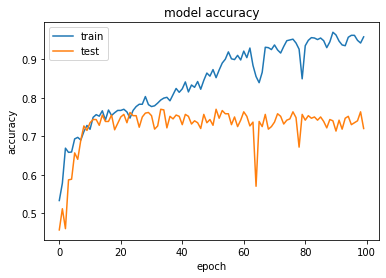

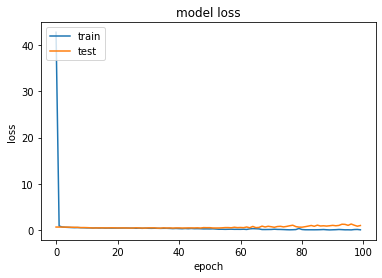

In [ ]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()